# Image Generation

InteropRouter makes it seamless to generate and edit images between different providers like `gpt-image-1.5` and Nano Banana Pro (`gemini-3-pro-image-preview`).

NOTE: Anthropic does not have an image generation model. If you pass the ImageGeneration tool with an Anthropic model, it will currently raise an error.


In [1]:
import base64
import os

from google import genai
from IPython.display import Image, display
from openai import AsyncOpenAI
from openai.types.responses import EasyInputMessageParam, WebSearchToolParam
from openai.types.responses.tool_param import ImageGeneration

from interop_router.router import Router
from interop_router.types import ChatMessage, RouterResponse

router = Router()
openai_client = AsyncOpenAI()
gemini_client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
router.register("openai", openai_client)
router.register("gemini", gemini_client)

messages: list[ChatMessage] = []

In [2]:
def display_generated_image(response: RouterResponse) -> None:
    """Extract and display any generated images from a router response."""
    for msg in response.output:
        message_data = msg.message
        if message_data.get("type") == "function_call_output":
            output = message_data.get("output", [])
            if isinstance(output, list):
                for item in output:
                    if isinstance(item, dict) and item.get("type") == "input_image":
                        image_url = item.get("image_url")
                        if isinstance(image_url, str) and image_url.startswith("data:image"):
                            b64_data = image_url.split(",", 1)[1]
                            image_bytes = base64.b64decode(b64_data)
                            display(Image(data=image_bytes))

/home/david/repos/interop-router/.venv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `ResponseOutputMessage` - serialized value may not be as expected [field_name='output', input_value=ResponseFunctionWebSearch... type='web_search_call'), input_type=ResponseFunctionWebSearch])
  PydanticSerializationUnexpectedValue(Expected `ResponseFileSearchToolCall` - serialized value may not be as expected [field_name='output', input_value=ResponseFunctionWebSearch... type='web_search_call'), input_type=ResponseFunctionWebSearch])
  PydanticSerializationUnexpectedValue(Expected `ResponseFunctionToolCall` - serialized value may not be as expected [field_name='output', input_value=ResponseFunctionWebSearch... type='web_search_call'), input_type=ResponseFunctionWebSearch])
  PydanticSerializationUnexpectedValue(PydanticSerializationUnexpectedValue: Expected `literal['url']` - serialized value may not be as 

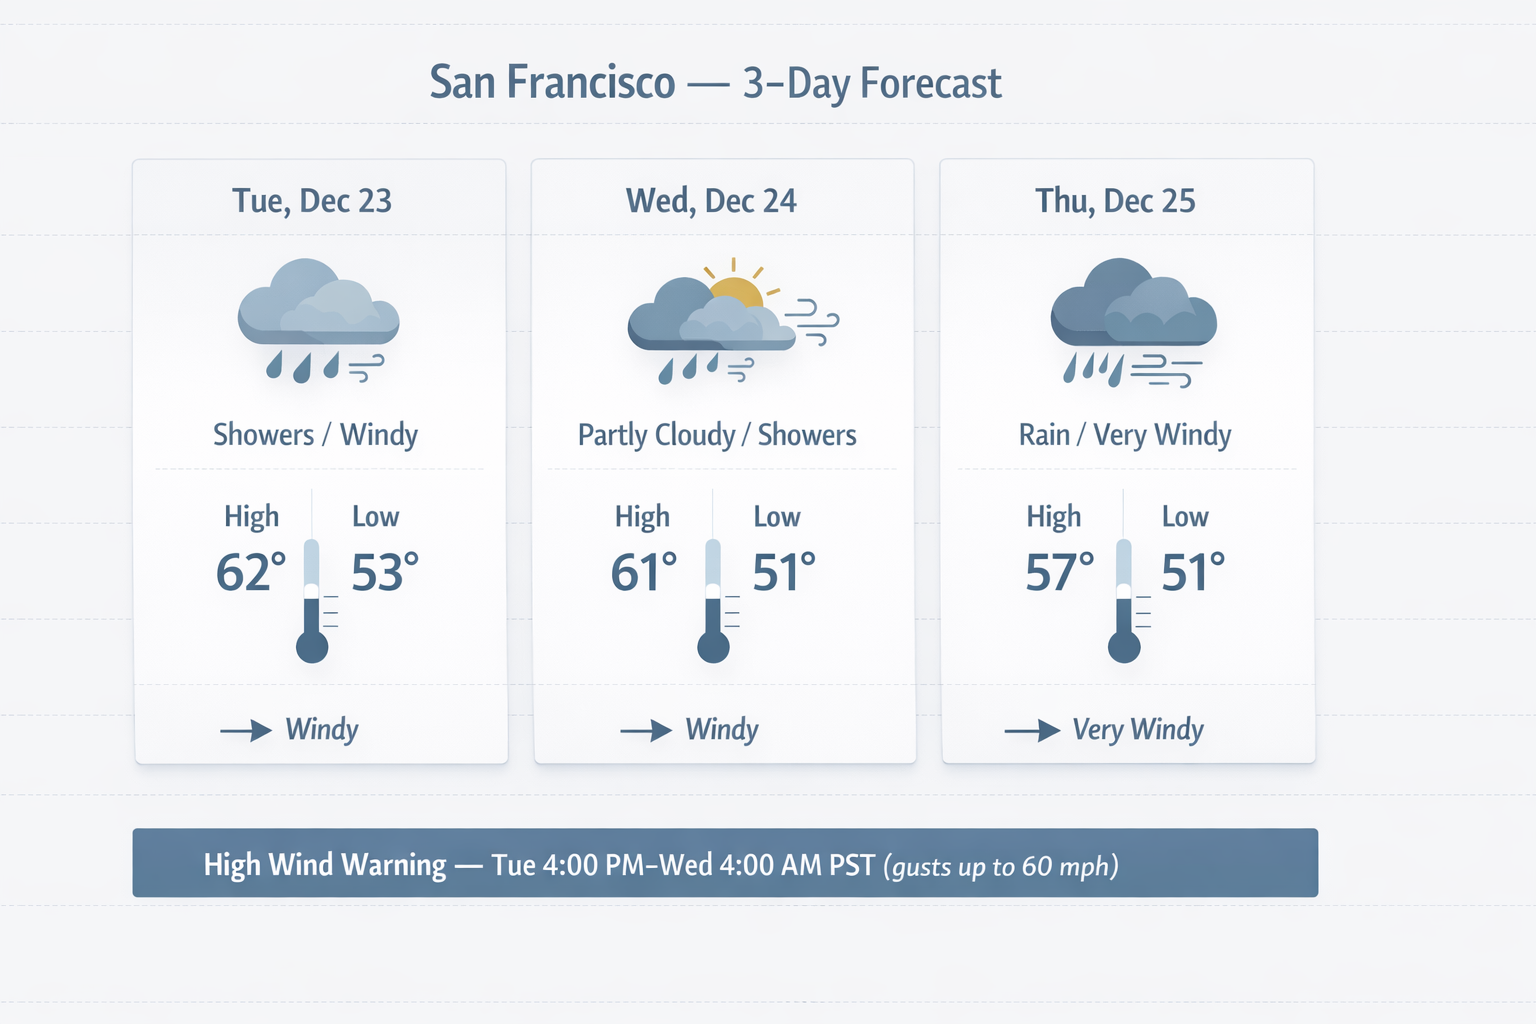

In [3]:
image_prompt = (
    "Visualize the current weather forecast for the next 3 days in San Francisco as a clean, modern weather chart."
)

messages.append(ChatMessage(message=EasyInputMessageParam(role="user", content=image_prompt)))
image_tool_openai = ImageGeneration(
    type="image_generation",
    model="gpt-image-1.5",
    quality="high",
    size="auto",
)
image_response = await router.create(
    input=messages,
    model="gpt-5.2",
    reasoning={"effort": "medium", "summary": "auto"},
    tools=[image_tool_openai, WebSearchToolParam(type="web_search")],
    include=["web_search_call.results", "web_search_call.action.sources", "reasoning.encrypted_content"],
)
messages.extend(image_response.output)
display_generated_image(image_response)

In [4]:
user_message_2 = "Thanks! What day looks best for a picnic?"
messages.append(ChatMessage(message=EasyInputMessageParam(role="user", content=user_message_2)))
response_2 = await router.create(
    input=messages,
    model="gemini-3-pro-preview",
    reasoning={"effort": "low", "summary": "auto"},
    include=["reasoning.encrypted_content"],
)
print(response_2)

RouterResponse(output=[ChatMessage(message={'id': 'c6a8a9a5-6687-496b-92c5-b5bdacbf58ec', 'type': 'reasoning', 'summary': [{'text': '**Determining the Ideal Picnic Day**\n\nOkay, so the user wants to figure out the best day for a picnic, judging from that weather chart I just gave them.  They\'re looking for the *best* day, which implies they want the most pleasant weather.  Let\'s see, the data I have covers San Francisco from December 23rd to 25th.\n\nLooking at it now, Tuesday the 23rd is out of the question, right off the bat.  "Showers / Windy" just screams "avoid at all costs" for an outdoor feast.  No one wants to deal with that for a picnic. \n\n\n', 'type': 'summary_text'}], 'status': 'completed', 'encrypted_content': 'Eq0DCqoDAXLI2nxl2GH4I94VASR17DnXpKb814l1o2Y3cnKCL7VyTnhjL7UHRYrd/zMpmZ7TKcVxzdNkaB5tC1ezVATuX4F/waiUZuDAL9SpePYO8EdFEAmlMv4OMSXfvKtBcuXSkDFr9a1HQE6K9ddtwUv2Kl2HLYjxNkZzS/h9jCBJrzsDM/d6Io6WTi0RDydQW1PpQOLJnk6jgDCH3nIfDTU+dSoWIoM5kkVdxxzSKbzBUFdB3LaCtPNu0Sx+YxPlC5

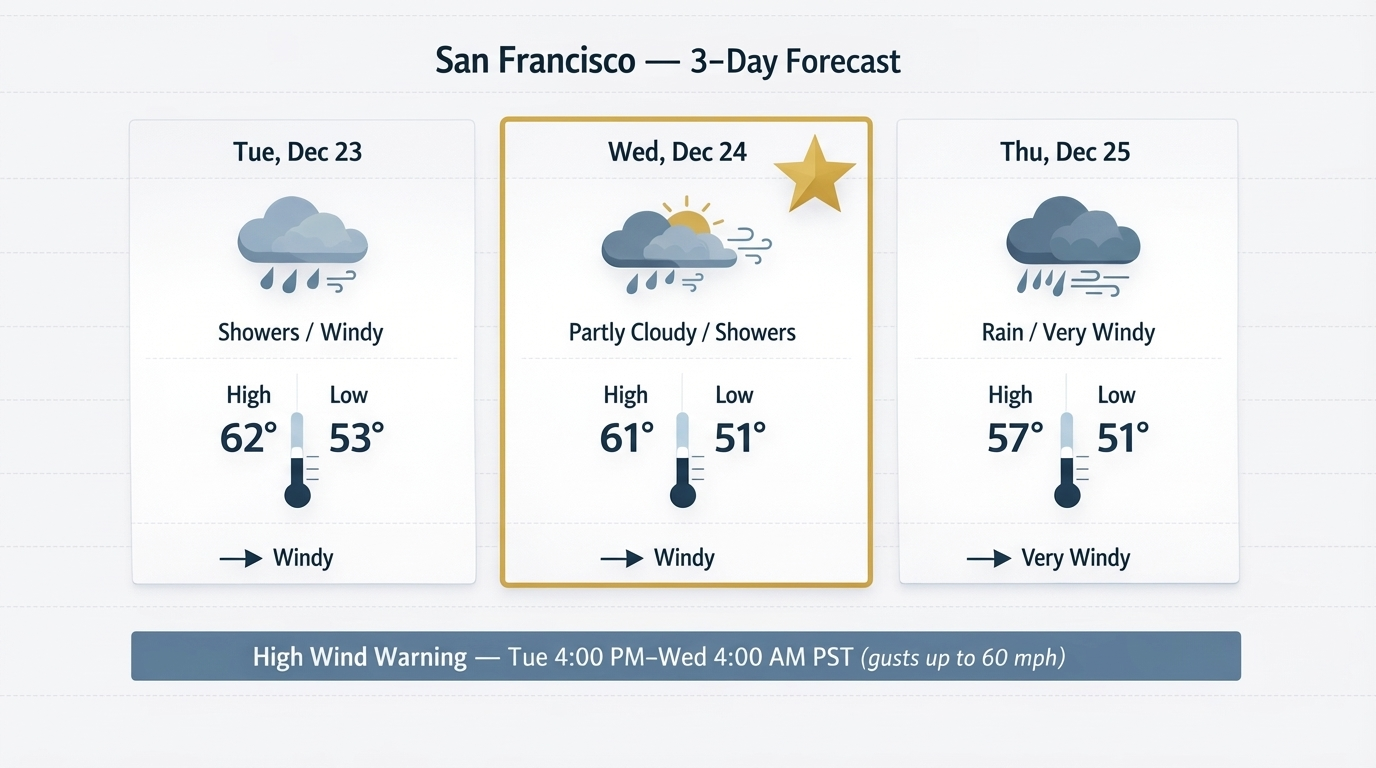

In [5]:
edit_image_message = "Can you update the weather chart to highlight the best picnic day with a star icon and outline? You must pick a day"
messages.append(
    ChatMessage(
        message=EasyInputMessageParam(
            role="user",
            content=edit_image_message,
        ),
        provider_kwargs={"gemini": {"image_config": {"aspect_ratio": "16:9"}}},
    )
)
image_tool_gemini = ImageGeneration(
    type="image_generation",
    model="gemini-3-pro-image-preview",
    quality="high",
    size="auto",
)
response3 = await router.create(
    input=messages,
    model="gemini-3-pro-preview",
    tools=[image_tool_gemini],
    reasoning={"effort": "medium", "summary": "auto"},
    include=["reasoning.encrypted_content"],
)
display_generated_image(response3)

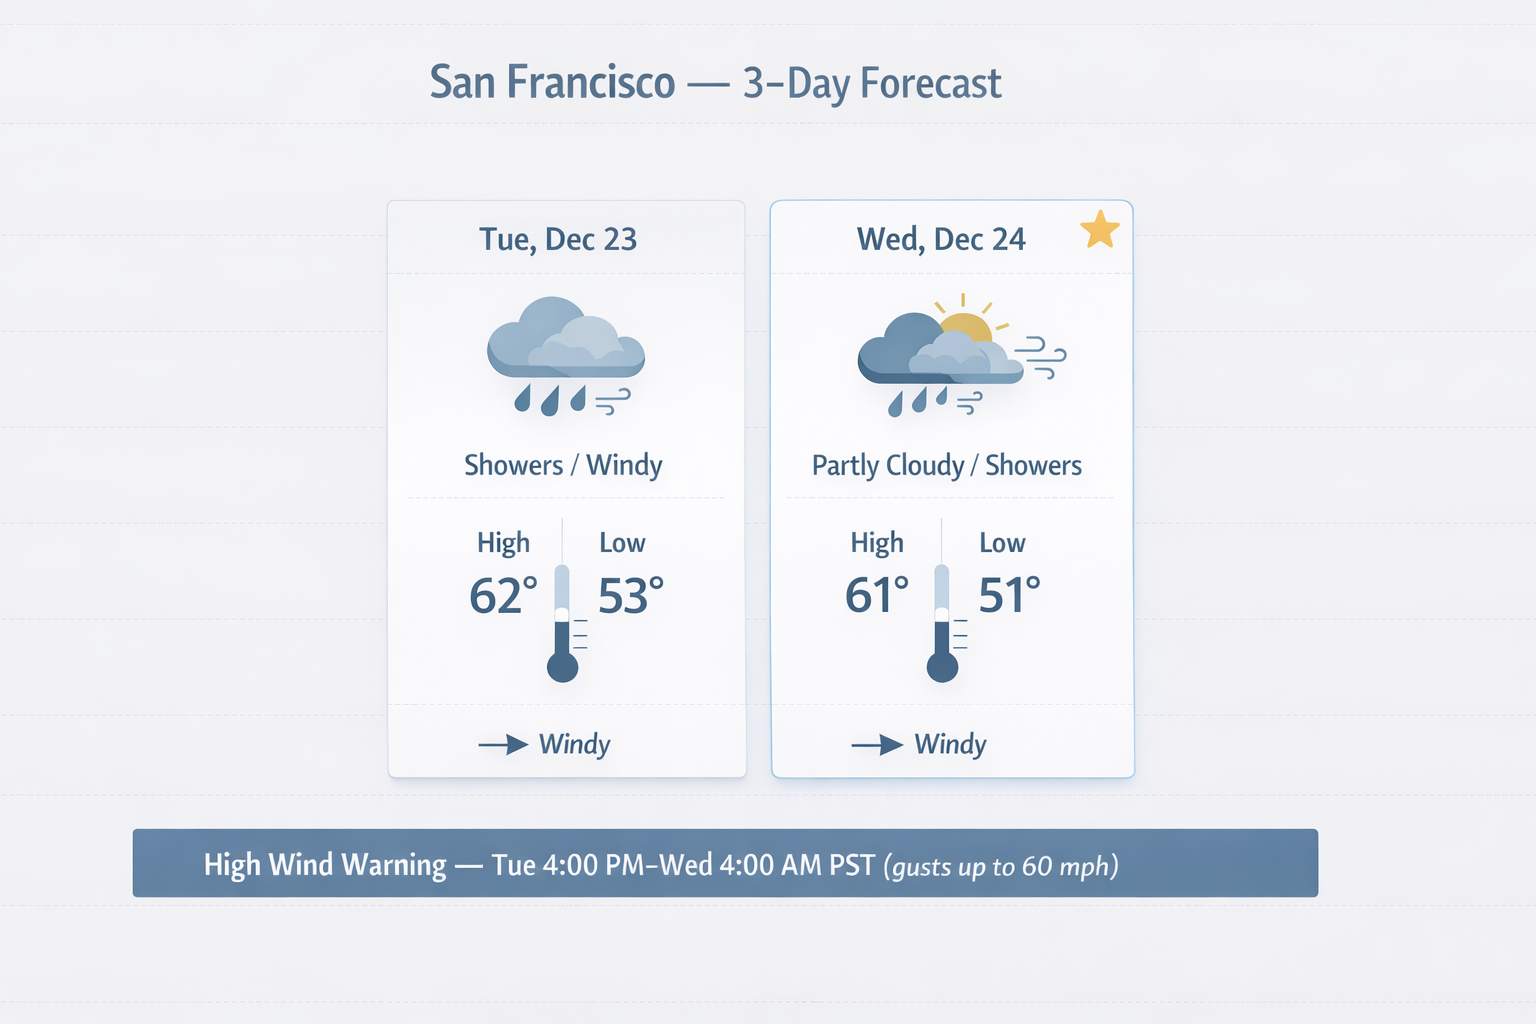

In [6]:
edit_image_message_2 = "Can you actually remove the third day and just leave the first two days on the chart? Leave everything else unchanged."
messages.append(
    ChatMessage(
        message=EasyInputMessageParam(
            role="user",
            content=edit_image_message_2,
        ),
    )
)
image_tool_openai_2 = ImageGeneration(
    type="image_generation",
    model="chatgpt-image-latest",
    quality="high",
    size="auto",
)
response3 = await router.create(
    input=messages,
    model="gpt-5.2",
    tools=[image_tool_openai_2],
    reasoning={"effort": "medium", "summary": "auto"},
    include=["reasoning.encrypted_content"],
)
display_generated_image(response3)